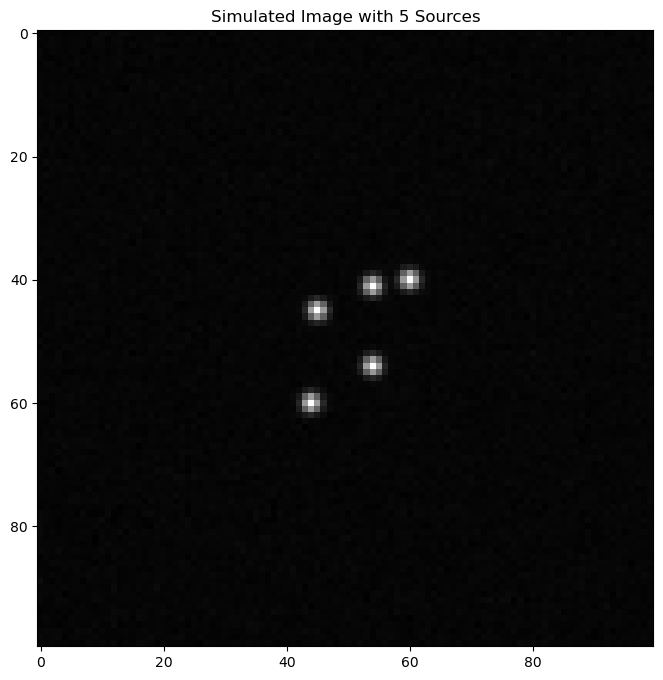

Source positions:
 [[40.70152283 60.62921056]
 [45.53721718 45.81548911]
 [54.68526297 54.2220599 ]
 [60.0974512  44.41893751]
 [41.81147013 54.7313196 ]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


image_size = (100, 100)
N = 5

mean = [50, 50]  
cov = [[50, 0], [0, 50]]  

source_positions = np.random.multivariate_normal(mean, cov, N)
image = np.zeros(image_size)

sigma = 1

for pos in source_positions:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
        temp_image = np.zeros_like(image)
        temp_image[x, y] = 1
        temp_image = gaussian_filter(temp_image, sigma=sigma)
        image += temp_image


noise_level = 0.001
image += noise_level * np.random.randn(*image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Simulated Image with {} Sources'.format(N))
plt.show()

print("Source positions:\n", source_positions)

In [11]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

image_data = image

max_N = 10

def gaussian_kernel(pos, sigma):
    x, y = pos[0], pos[1]
    grid_x, grid_y = np.meshgrid(np.arange(100), np.arange(100))
    kernel = np.exp(-((grid_x - x)**2 + (grid_y - y)**2) / (2 * sigma**2))
    return kernel


with pm.Model() as model:

    # 先验分布
    N = pm.Poisson('N', mu=5)
    x = pm.Normal('x', mu=50, sigma=10, shape=(max_N, 2))  
    
    # 似然函数 
    def generate_image(x, N):
        image = 0
        for i in range(max_N): 
            is_active = tt.switch(tt.lt(i, N), 1, 0)  
            kernel = gaussian_kernel(x[i], sigma=5)  
            image += is_active * kernel
        return image + pm.Normal('noise', mu=0, sigma=1, shape=image_data.shape)
    
    observed_image = pm.Deterministic('observed_image', generate_image(x, N))
    
    likelihood = pm.Normal('likelihood', mu=observed_image, sigma=1, observed=image_data)

with model:
    # 采样阶段：在每次迭代中，N 和 x 的值都会根据当前的后验概率更新，这意味着它们的值会在整个采样过程中不断变化。
    # 调优阶段：为了让采样器找到合适的参数配置，从而在正式采样阶段能够更高效地探索后验分布。
    trace = pm.sample(20, tune=10)

print("Source count:", trace['N'].mean())
print("Source positions:", trace['x'][:, :trace['N'].mean().astype(int)])

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/home/lvjm/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 20 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [N]
>NUTS: [noise, x]


Sampling 4 chains for 10 tune and 20 draw iterations (40 + 80 draws total) took 376 seconds.
/home/lvjm/anaconda3/lib/python3.10/site-packages/pymc3/sampling.py:665: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.9889198252792711, but should be close to 0.8. Try to increase the number of tuning steps.


Source count: 1.475
Source positions: [[[63.92464088 56.94134162]]

 [[61.80078067 52.64942601]]

 [[61.92110016 52.38533481]]

 [[67.61591803 52.4689259 ]]

 [[30.62379748 63.96712171]]

 [[52.32190803 53.01500017]]

 [[42.87102723 43.12791862]]

 [[29.25923301 40.05087196]]

 [[29.09634775 32.50469637]]

 [[43.47066241 61.81773558]]

 [[48.76491893 61.63266203]]

 [[61.33719381 46.99391878]]

 [[35.01688596 47.18282456]]

 [[65.43936016 22.35342903]]

 [[36.06020944 65.07384547]]

 [[41.78950742 64.52833185]]

 [[43.52267615 33.39318994]]

 [[54.53612564 68.59830598]]

 [[49.76704325 61.9551403 ]]

 [[47.82937766 37.41137291]]

 [[51.93702077 77.50535233]]

 [[49.99526013 23.322462  ]]

 [[44.22506311 42.80971329]]

 [[41.21734832 53.87970527]]

 [[48.08433432 51.97229569]]

 [[56.8341374  44.59304304]]

 [[53.6498533  40.60961132]]

 [[40.08703508 49.32563597]]

 [[27.02901425 42.33438085]]

 [[26.4338974  36.83042798]]

 [[71.14176287 62.51121013]]

 [[71.52415717 62.99037223]]

 [

Got error No model on context stack. trying to find log_likelihood in translation.
/home/lvjm/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


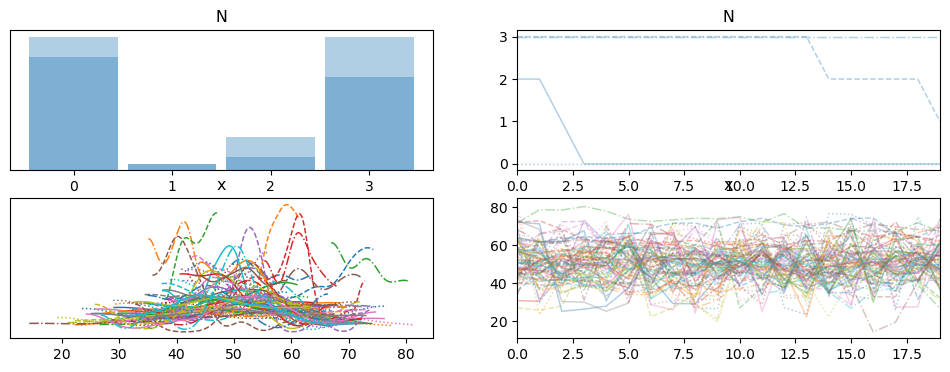

In [14]:
import arviz as az

az.plot_trace(trace, var_names=['N', 'x'])

plt.show()

/tmp/ipykernel_11415/787406987.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


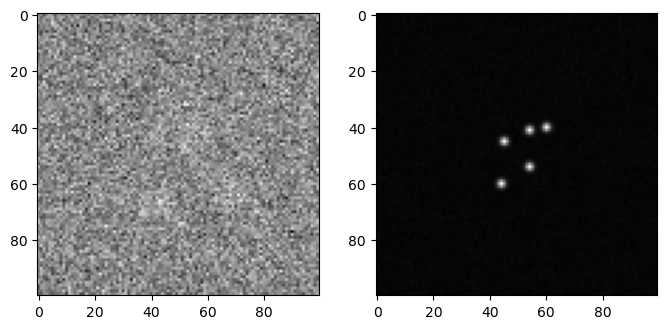

In [16]:
trace['observed_image'].mean(axis=0)

plt.subplots(figsize=(8, 8))
plt.subplot(121)
plt.imshow(trace['observed_image'][-1], cmap='gray')
plt.subplot(122)
plt.imshow(image_data, cmap='gray')



In [17]:
# 获取最后一个样本的值
last_sample_n = trace['N'][-1]
last_sample_x = trace['x'][-1]

print("Last sample of N:", last_sample_n)
print("Last sample of x:", last_sample_x)

Last sample of N: 3
Last sample of x: [[54.81930208 43.12155033]
 [66.88933179 61.86626926]
 [41.16604579 67.61884776]
 [47.18787395 60.73317914]
 [42.15566037 54.75844568]
 [46.31370483 69.7010506 ]
 [26.54590195 54.15370404]
 [54.06971534 61.14159812]
 [46.26648804 60.40846517]
 [30.74289677 57.13583409]]


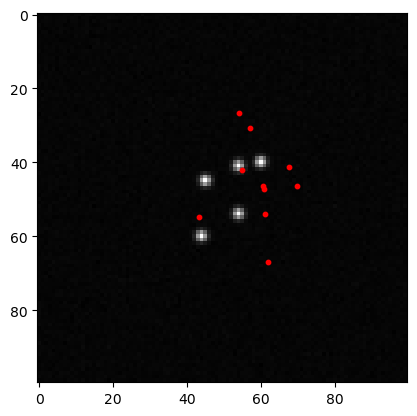

In [26]:
plt.scatter(last_sample_x[:, 1], last_sample_x[:, 0], c='r', s=10)

plt.imshow(image_data, cmap='gray')
